<a href="https://colab.research.google.com/github/Saksham0905/creditcard/blob/main/creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv("/content/fraudTest.csv")
df = df.dropna(subset=['is_fraud'])
df = df.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last',
              'street', 'city', 'state', 'zip', 'unix_time', 'job', 'dob'], axis=1, errors='ignore')



print("Columns:", df.columns.tolist())
print("Sample rows:\n", df.head())


Columns: ['Unnamed: 0', 'category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'trans_num', 'merch_lat', 'merch_long', 'is_fraud']
Sample rows:
    Unnamed: 0        category    amt gender      lat      long  city_pop  \
0           0   personal_care   2.86      M  33.9659  -80.9355  333497.0   
1           1   personal_care  29.84      F  40.3207 -110.4360     302.0   
2           2  health_fitness  41.28      F  40.6729  -73.5365   34496.0   
3           3        misc_pos  60.05      M  28.5697  -80.8191   54767.0   
4           4          travel   3.19      M  44.2529  -85.0170    1126.0   

                          trans_num  merch_lat  merch_long  is_fraud  
0  2da90c7d74bd46a0caf3777415b3ebd3  33.986391  -81.200714       0.0  
1  324cc204407e99f51b0d6ca0055005e7  39.450498 -109.960431       0.0  
2  c81755dbbbea9d5c77f094348a7579be  40.495810  -74.196111       0.0  
3  2159175b9efe66dc301f149d3d5abf8c  28.812398  -80.883061       0.0  
4  57ff021bd3f328f8738bb535c302a31b  44.95

In [ ]:
# Encode categorical features
df = pd.get_dummies(df, columns=['category', 'gender'], drop_first=True)


X = df.drop('is_fraud', axis=1)
y = df['is_fraud']
# Check data types
print(X.dtypes)

# Drop any remaining non-numeric columns
non_numeric = X.select_dtypes(include='object').columns
print("Non-numeric columns being dropped:", non_numeric.tolist())
X = X.drop(columns=non_numeric)

Unnamed: 0                   int64
amt                        float64
lat                        float64
long                       float64
city_pop                   float64
trans_num                   object
merch_lat                  float64
merch_long                 float64
category_food_dining          bool
category_gas_transport        bool
category_grocery_net          bool
category_grocery_pos          bool
category_health_fitness       bool
category_home                 bool
category_kids_pets            bool
category_misc_net             bool
category_misc_pos             bool
category_personal_care        bool
category_shopping_net         bool
category_shopping_pos         bool
category_travel               bool
gender_M                      bool
dtype: object
Non-numeric columns being dropped: ['trans_num']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("🔹 Logistic Regression:\n", classification_report(y_test, y_pred_lr))

🔹 Logistic Regression:
               precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     18587
         1.0       0.02      0.78      0.05        77

    accuracy                           0.87     18664
   macro avg       0.51      0.82      0.49     18664
weighted avg       0.99      0.87      0.92     18664



In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("🔹 Random Forest:\n", classification_report(y_test, y_pred_rf))







🔹 Random Forest:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18587
         1.0       0.96      0.58      0.73        77

    accuracy                           1.00     18664
   macro avg       0.98      0.79      0.86     18664
weighted avg       1.00      1.00      1.00     18664



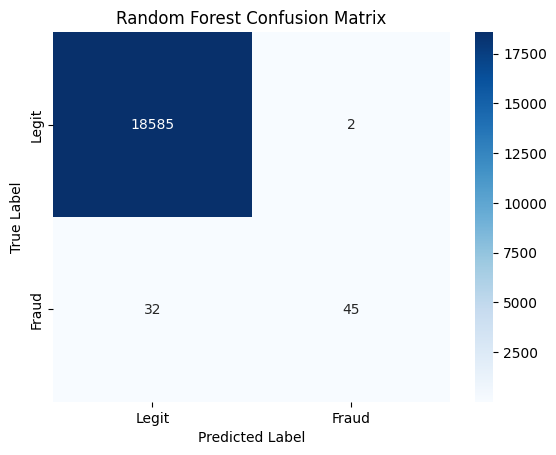

In [ ]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_cm(y_test, y_pred_rf, "Random Forest Confusion Matrix")

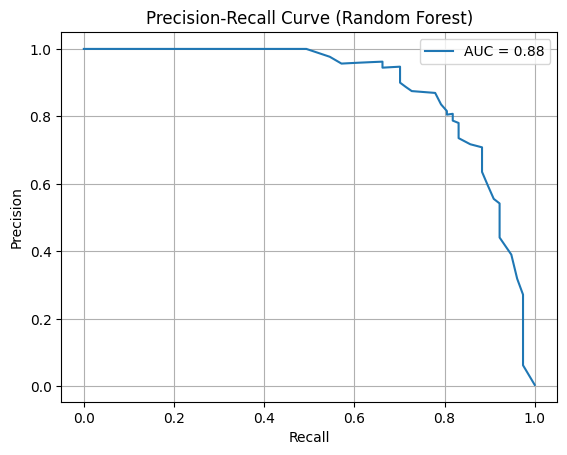

In [ ]:
probs = rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Take a random fraud or legit sample from the dataset
sample_row = df[df['is_fraud'] == 0].sample(1)  # Change to 1 for fraud sample


In [ ]:
# Drop the target column
sample_X = sample_row.drop('is_fraud', axis=1)

# Drop any object-type columns
sample_X = sample_X.drop(columns=sample_X.select_dtypes(include='object').columns)

# Make sure it has the same columns as training data
sample_X = sample_X.reindex(columns=X.columns, fill_value=0)

# Scale
sample_X_scaled = scaler.transform(sample_X)
# Predict class and probability
prediction = rf.predict(sample_X_scaled)
probability = rf.predict_proba(sample_X_scaled)

print("🧾 Prediction:", "FRAUD" if prediction[0] == 1 else "LEGIT")



🧾 Prediction: LEGIT
